## plot the hist of summation of values in each cell 

(114,) 350


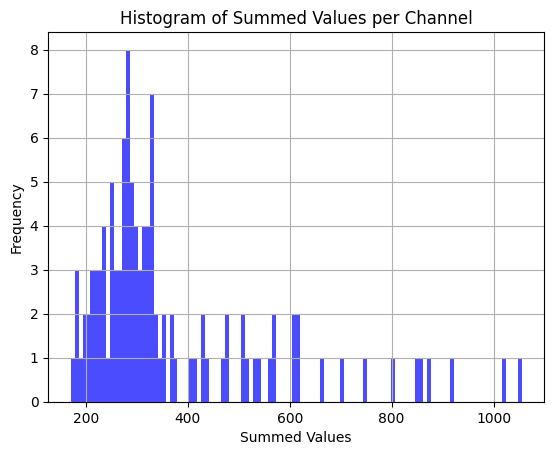

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming num_ch is known
# num_ch = 10
# data = np.random.randint(0, 5, size=(1000, 1000, num_ch))

# Convert values greater than zero to one
channels[channels > 0] = 1
num_ch = channels.shape[2] 
# Sum values in each channel
sums = channels.sum(axis=(0, 1))

print(sums.shape, sums[1])
# Plot histogram of summed values
plt.hist(sums[1:], bins=num_ch, color='blue', alpha=0.7)
plt.title('Histogram of Summed Values per Channel')
plt.xlabel('Summed Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## sahar code 

In [1]:
import numpy as np
from skimage import io, color, measure, segmentation, morphology
from scipy import ndimage as ndi
import cv2
import czifile

def dilate_mask(mask, size):
    selem = morphology.disk(size)
    dilated_mask = morphology.dilation(mask, selem)
    return dilated_mask

def process_image(mask_path):

    # print(image.shape)

    # Load the label image
    img = io.imread(mask_path)

    # Ensure the image is 2D if it has a color channel
    if img.ndim == 3:
        img = color.rgb2gray(img)

    # Apply a binary threshold to the image
    binary_img = img > 0

    # Compute the distance transform
    distance = ndi.distance_transform_edt(binary_img)

    # Find local maxima in the distance transform
    local_maxi = morphology.local_maxima(distance)

    # Label the local maxima as markers for the watershed
    markers = measure.label(local_maxi)

    # Apply watershed segmentation
    label2 = segmentation.watershed(-distance, markers, mask=binary_img)
    labels = morphology.area_opening(label2, 130)

    # Get the number of unique objects after watershed
    num_objects = labels.max()
    print("Number of objects:", num_objects)

    # Process each object to create inner part masks
    props = measure.regionprops(labels)
    all_masks = np.zeros((len(props), img.shape[0], img.shape[1]), dtype=np.uint8)

    for nid, prop in enumerate(props):
        output_image = np.zeros_like(img, dtype=np.uint8)
        region_coords = prop.coords
        output_image[region_coords[:, 0], region_coords[:, 1]] = 1

        # Define the erosion kernel size
        kernel_size = 3
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Perform erosion
        eroded_image = cv2.erode(output_image, kernel, iterations=1)
        dapi_dilated = dilate_mask(output_image, 5)

        # Create a mask to exclude the inner part
        inner_part_mask = dapi_dilated - eroded_image

        # Store the inner_part_mask in the array
        all_masks[nid] = inner_part_mask

    return all_masks

import numpy as np
import matplotlib.pyplot as plt

def calculate_bounding_boxes(objects_array, padding=50):
    bounding_boxes = []
    height, width = objects_array.shape[1], objects_array.shape[2]  # Assuming shape [num_objects, H, W]
    
    for i in range(objects_array.shape[0]):
        object_slice = objects_array[i, :, :]
        
        # Find non-zero points (where object exists)
        coords = np.column_stack(np.where(object_slice > 0))
        
        if coords.size == 0:
            continue
        
        # Determine bounding box coordinates with padding
        x_min, y_min = coords.min(axis=0) - padding
        x_max, y_max = coords.max(axis=0) + padding
        
        # Ensure the coordinates do not go out of image boundaries
        x_min = max(x_min, 0)
        y_min = max(y_min, 0)
        x_max = min(x_max, width)
        y_max = min(y_max, height)
        
        # Append coordinates as (x_min, y_min, width, height)
        bounding_boxes.append([y_min, x_min, y_max - y_min, x_max - x_min])
        
    return bounding_boxes

def extract_patches(image, mask, bounding_boxes):

    
    image_patches = []
    mask_patches = []
    
    for i, box in enumerate(bounding_boxes):
        # print("box:", box)
        y_min, x_min, width, height = box
        
        # Check if width or height are negative
        if width < 0 or height < 0:
            print(f"Skipping box with invalid dimensions: {box}")
            continue
        
        # Extract patches from both image and mask using the same bounding box
        image_patch = image[:, x_min:x_min + height, y_min:y_min + width]
        mask_patch = mask[i, x_min:x_min + height, y_min:y_min + width]

        print("image_patch.shape:", image_patch.shape)
        print("mask_patch.shape:", mask_patch.shape)        

        image_patches.append(image_patch)
        mask_patches.append(mask_patch)
    
    return image_patches, mask_patches


# Example usage
# Load the main image
image_path = '/home/sshabani/projects/Grad_CAMO/data/lymphos/A1818_P0025_4MGRTumor_2.czi'
image = czifile.imread(image_path)
# image = image[:, :1024, :1280, 0]

mask_path = '/home/sshabani/projects/Grad_CAMO/data/lymphos/A1818_P0025_4MGRTumor_2_mask.png'
mask_channels = process_image( mask_path)


# Calculate bounding boxes with padding
bounding_boxes = calculate_bounding_boxes(mask_channels, padding=10)

# Extract patches from both the target image and the mask
image_patches, mask_patches = extract_patches(image, mask_channels, bounding_boxes)

print(len(image_patches), len(mask_patches))
print(image_patches[0].shape)
print(mask_patches[0].shape)

# print(img_patch.shape)
# Display the first few patches
# for i, (img_patch, msk_patch) in enumerate(zip(image_patches, mask_patches)):
#     # print(img_patch.shape)
#     # print(msk_patch.shape)
#     plt.figure(figsize=(12, 6))
    
#     plt.subplot(1, 4, 1)
#     plt.imshow(img_patch[0,:,:,0])
#     plt.title(f'Image Patch {i+1}')
    
#     plt.subplot(1, 4, 2)
#     plt.imshow(img_patch[1,:,:,0])
#     plt.title(f'Mask Patch {i+1}')

#     plt.subplot(1, 4, 3)
#     plt.imshow(img_patch[3,:,:,0])
#     plt.title(f'Mask Patch {i+1}')

#     plt.subplot(1, 4, 4)
#     plt.imshow(msk_patch[:,:])
#     plt.title(f'Mask Patch {i+1}')

#     plt.show()




Number of objects: 169
image_patch.shape: (6, 42, 49, 1)
mask_patch.shape: (42, 49)
image_patch.shape: (6, 49, 50, 1)
mask_patch.shape: (49, 50)
image_patch.shape: (6, 41, 46, 1)
mask_patch.shape: (41, 46)
image_patch.shape: (6, 32, 42, 1)
mask_patch.shape: (32, 42)
image_patch.shape: (6, 41, 46, 1)
mask_patch.shape: (41, 46)
image_patch.shape: (6, 48, 50, 1)
mask_patch.shape: (48, 50)
image_patch.shape: (6, 47, 48, 1)
mask_patch.shape: (47, 48)
Skipping box with invalid dimensions: [np.int64(1119), np.int64(95), np.int64(-95), np.int64(47)]
image_patch.shape: (6, 46, 47, 1)
mask_patch.shape: (46, 47)
Skipping box with invalid dimensions: [np.int64(1099), np.int64(121), np.int64(-75), np.int64(51)]
image_patch.shape: (6, 42, 46, 1)
mask_patch.shape: (42, 46)
image_patch.shape: (6, 50, 44, 1)
mask_patch.shape: (50, 44)
image_patch.shape: (6, 45, 51, 1)
mask_patch.shape: (45, 51)
image_patch.shape: (6, 50, 45, 1)
mask_patch.shape: (50, 45)
image_patch.shape: (6, 49, 46, 1)
mask_patch.sha

In [10]:
import os 

# Example usage
# Load the main image
image_path = '/home/sshabani/projects/Grad_CAMO/data/lymphos/A1818_P0103_4MGLTumor_5.czi'
image = czifile.imread(image_path)
# image = image[:, :1024, :1280, 0]

mask_path = '/home/sshabani/projects/Grad_CAMO/data/lymphos/A1818_P0103_4MGLTumor_5_mask.tif'
mask_channels = process_image( mask_path)
save_directory = '/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/'  # Set the desired path


# Calculate bounding boxes with padding
bounding_boxes = calculate_bounding_boxes(mask_channels, padding=10)
    
for i, box in enumerate(bounding_boxes):
    # print("box:", box)
    y_min, x_min, width, height = box
    
    # Check if width or height are negative
    if width < 0 or height < 0:
        print(f"Skipping box with invalid dimensions: {box}")
        continue
    
    # Extract patches from both image and mask using the same bounding box
    image_patch = image[:, x_min:x_min + height, y_min:y_min + width,0]
    mask_patch = mask_channels[i, x_min:x_min + height, y_min:y_min + width]

    print("image_patch.shape:", image_patch.shape)
    print("mask_patch.shape:", mask_patch.shape)        
    # Saving the patches
    image_patch_path = os.path.join(save_directory, f'image/image_patch_{i}.npy')
    mask_patch_path = os.path.join(save_directory, f'mask/mask_patch_{i}.npy')
    np.save(image_patch_path, image_patch)
    np.save(mask_patch_path, mask_patch)
 

IndexError: tuple index out of range

In [8]:
import numpy as np
from skimage import io, color, measure, segmentation, morphology
from scipy import ndimage as ndi
import cv2
import czifile

def dilate_mask(mask, size):
    selem = morphology.disk(size)
    dilated_mask = morphology.dilation(mask, selem)
    return dilated_mask

def process_image(mask_path):

    # print(image.shape)

    # Load the label image
    img = io.imread(mask_path)

    # Ensure the image is 2D if it has a color channel
    if img.ndim == 3:
        img = color.rgb2gray(img)

    # Apply a binary threshold to the image
    binary_img = img > 0

    # Compute the distance transform
    distance = ndi.distance_transform_edt(binary_img)

    # Find local maxima in the distance transform
    local_maxi = morphology.local_maxima(distance)

    # Label the local maxima as markers for the watershed
    markers = measure.label(local_maxi)

    # Apply watershed segmentation
    label2 = segmentation.watershed(-distance, markers, mask=binary_img)
    labels = morphology.area_opening(label2, 130)

    # Get the number of unique objects after watershed
    num_objects = labels.max()
    print("Number of objects:", num_objects)

    # Process each object to create inner part masks
    props = measure.regionprops(labels)
    all_masks = np.zeros((len(props), img.shape[0], img.shape[1]), dtype=np.uint8)

    for nid, prop in enumerate(props):
        output_image = np.zeros_like(img, dtype=np.uint8)
        region_coords = prop.coords
        output_image[region_coords[:, 0], region_coords[:, 1]] = 1

        # Define the erosion kernel size
        kernel_size = 3
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Perform erosion
        eroded_image = cv2.erode(output_image, kernel, iterations=1)
        dapi_dilated = dilate_mask(output_image, 5)

        # Create a mask to exclude the inner part
        inner_part_mask = dapi_dilated - eroded_image

        # Store the inner_part_mask in the array
        all_masks[nid] = inner_part_mask

    return all_masks

import numpy as np
import matplotlib.pyplot as plt

def calculate_bounding_boxes(objects_array, padding=50):
    bounding_boxes = []
    height, width = objects_array.shape[1], objects_array.shape[2]  # Assuming shape [num_objects, H, W]
    
    for i in range(objects_array.shape[0]):
        object_slice = objects_array[i, :, :]
        
        # Find non-zero points (where object exists)
        coords = np.column_stack(np.where(object_slice > 0))
        
        if coords.size == 0:
            continue
        
        # Determine bounding box coordinates with padding
        x_min, y_min = coords.min(axis=0) - padding
        x_max, y_max = coords.max(axis=0) + padding
        
        # Ensure the coordinates do not go out of image boundaries
        x_min = max(x_min, 0)
        y_min = max(y_min, 0)
        x_max = min(x_max, width)
        y_max = min(y_max, height)
        
        # Append coordinates as (x_min, y_min, width, height)
        bounding_boxes.append([y_min, x_min, y_max - y_min, x_max - x_min])
        
    return bounding_boxes

def extract_patches(image, mask, bounding_boxes):

    
    image_patches = []
    mask_patches = []
    
    for i, box in enumerate(bounding_boxes):
        # print("box:", box)
        y_min, x_min, width, height = box
        
        # Check if width or height are negative
        if width < 0 or height < 0:
            print(f"Skipping box with invalid dimensions: {box}")
            continue
        
        # Extract patches from both image and mask using the same bounding box
        image_patch = image[:, x_min:x_min + height, y_min:y_min + width]
        mask_patch = mask[i, x_min:x_min + height, y_min:y_min + width]

        print("image_patch.shape:", image_patch.shape)
        print("mask_patch.shape:", mask_patch.shape)        

        image_patches.append(image_patch)
        mask_patches.append(mask_patch)
    
    return image_patches, mask_patches



def process_directory(image_dir, mask_dir, save_dir):
    # Ensure directories for saving patches exist
    os.makedirs(os.path.join(save_dir, 'image'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'mask'), exist_ok=True)
    
    # List all images in the image directory
    for filename in os.listdir(image_dir):
        if filename.endswith(".czi"):  # Assuming CZI files, modify as needed
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.czi', '_mask.png'))
            
            if not os.path.exists(mask_path):
                print(f"No corresponding mask found for {filename}")
                continue

            print(f"Processing {filename}")
            image = czifile.imread(image_path)
            mask_channels = process_image(mask_path)

            # Calculate bounding boxes with padding
            bounding_boxes = calculate_bounding_boxes(mask_channels, padding=10)
            
            for i, box in enumerate(bounding_boxes):
                y_min, x_min, width, height = box
                if width < 0 or height < 0:
                    print(f"Skipping box with invalid dimensions: {box}")
                    continue

                # Extract patches from both image and mask using the same bounding box
                image_patch = image[:, x_min:x_min + height, y_min:y_min + width, 0]
                mask_patch = mask_channels[i, x_min:x_min + height, y_min:y_min + width]

                # Save the patches
                image_patch_path = os.path.join(save_dir, 'image', f'image_patch_{i}_{filename}.npy')
                mask_patch_path = os.path.join(save_dir, 'mask', f'mask_patch_{i}_{filename}.npy')
                np.save(image_patch_path, image_patch)
                np.save(mask_patch_path, mask_patch)

# Usage example
image_dir = '/home/sshabani/projects/Grad_CAMO/data/lymphos/'
mask_dir = '/home/sshabani/projects/Grad_CAMO/data/lymphos/'
save_directory = '/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/'

process_directory(image_dir, mask_dir, save_directory)

Processing A1818_P0103_4MGLTumor_5_mask.tif


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

(1024, 1280)
0 255


/tmp/ipykernel_3454940/2813003874.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(image_path)


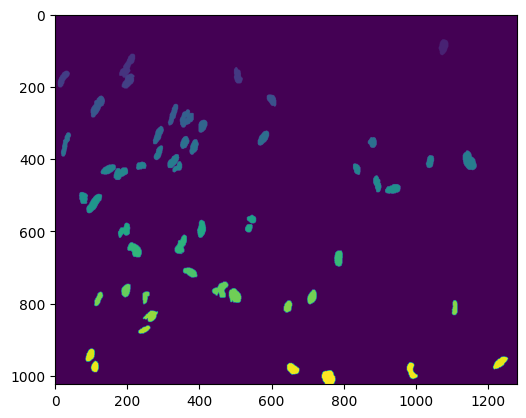

In [55]:
import imageio

# Load the image
image_path = '/home/sshabani/projects/Grad_CAMO/data/non_lymphos/A1818_P0007_4MGLTumor_1_mask.png'
mask = imageio.imread(image_path)

print(mask.shape)  # Print the dimensions of the image
print(mask.min(), mask.max())


plt.imshow(mask)

In [61]:
import imageio
import czifile
# Load the image
image_path = '/home/sshabani/projects/Grad_CAMO/data/non_lymphos/A1818_P0007_4MGLTumor_1.czi'
img = czifile.imread(image_path)

img=img[:,:1024,:1280,0]

print(img.shape)  # Print the dimensions of the image
print(img.min(), img.max())

# plt.imshow(img)

(6, 1024, 1280)
42 4095


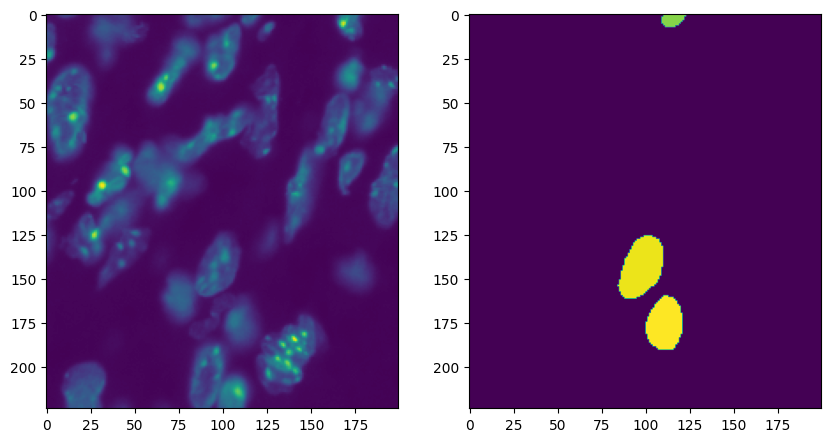

In [65]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(img[0,800:,:200])

plt.subplot(1,2,2)
plt.imshow(mask[800:,:200])



(6, 43, 24)
(43, 24)


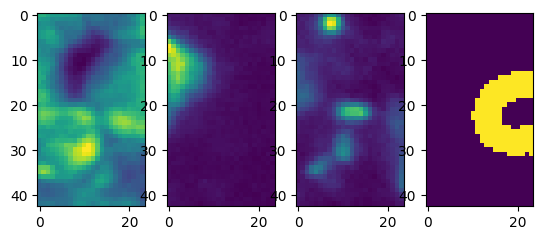

In [41]:
import matplotlib.pyplot as plt 
import numpy as np

img = np.load("/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/image/A1820_P0536_4MGRTumor_1_image_patch_76.npy")

print(img.shape)


msk = np.load("/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/mask/A1820_P0536_4MGRTumor_1_mask_patch_76.npy")

print(msk.shape)


plt.subplot(1,4,1)
plt.imshow(img[0,:,:])

plt.subplot(1,4,2)
plt.imshow(img[1,:,:])

plt.subplot(1,4,3)
plt.imshow(img[3,:,:])

plt.subplot(1,4,4)
plt.imshow(msk)


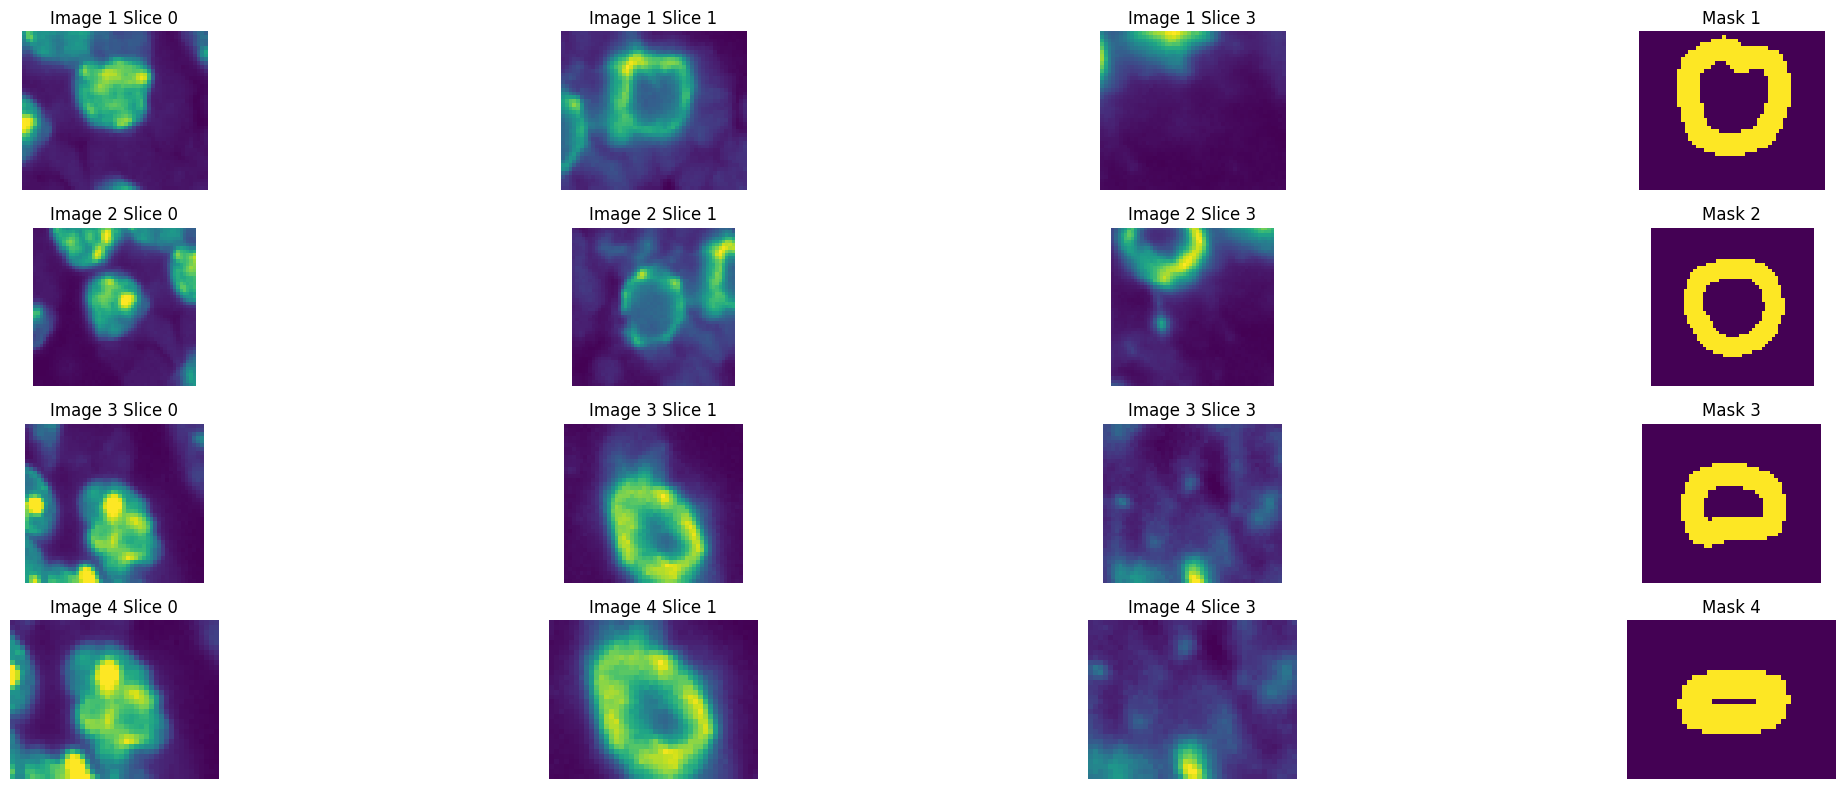

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Paths for images and masks
image_paths = [
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/image/A1818_P0025_4MGRTumor_2_image_patch_0.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/image/A1818_P0025_4MGRTumor_2_image_patch_1.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/image/A1818_P0025_4MGRTumor_2_image_patch_2.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/image/A1818_P0025_4MGRTumor_2_image_patch_3.npy"
]

mask_paths = [
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/mask/A1818_P0025_4MGRTumor_2_mask_patch_0.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/mask/A1818_P0025_4MGRTumor_2_mask_patch_1.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/mask/A1818_P0025_4MGRTumor_2_mask_patch_2.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/mask/A1818_P0025_4MGRTumor_2_mask_patch_3.npy"
]

# Loading images and masks
images = [np.load(path) for path in image_paths]
masks = [np.load(path) for path in mask_paths]

# Plotting configuration
plt.figure(figsize=(24, 8))  # Adjusted figure size to accommodate 12 subplots

# Display three slices from each image and the corresponding mask
for idx, img in enumerate(images):
    # Plotting the first slice
    plt.subplot(4, 4, 1 + idx * 4)
    plt.imshow(img[0, :, :])
    plt.title(f"Image {idx + 1} Slice 0")
    plt.axis('off')

    # Plotting the second slice
    plt.subplot(4, 4, 2 + idx * 4)
    plt.imshow(img[1, :, :])
    plt.title(f"Image {idx + 1} Slice 1")
    plt.axis('off')

    # Plotting the third slice
    plt.subplot(4, 4, 3 + idx * 4)
    plt.imshow(img[3, :, :])
    plt.title(f"Image {idx + 1} Slice 3")
    plt.axis('off')

    # Plotting the mask
    plt.subplot(4, 4, 4 + idx * 4)
    plt.imshow(masks[idx])
    plt.title(f"Mask {idx + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()
